In [287]:
import os
from zipfile import ZipFile
import shutil
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
import scipy
import glob
import cv2
from IPython.display import clear_output
from tensorflow.keras.applications.inception_v3 import InceptionV3

import util


In [288]:
executed_on_colab = False

if executed_on_colab:
    from google.colab import drive
    drive.mount('/content/gdrive')
    os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
    %cd /content/gdrive/My Drive/Kaggle
    %pwd
    !kaggle datasets download -d grassknoted/asl-alphabet

In [289]:
zip_path = "./archive.zip"
data_path = "./data/"

#with ZipFile(zip_path, 'r') as zipObj:
#    zipObj.extractall(data_path)
#    print(f"Extracted to {data_path}")

In [290]:
# The extracted data is uneccesary nested - move the inner folder to the root of training/test folders respectively
old_training_data_path = "./data/asl_alphabet_train/"
old_test_data_path = "./data/asl_alphabet_test/"

training_data_path = "./data/training/"
test_data_path = "./data/validation/"

source_training_data_path = os.path.join(old_training_data_path, "asl_alphabet_train/")
source_test_data_path = os.path.join(old_test_data_path, "asl_alphabet_test/")

In [4]:
shutil.copytree(source_training_data_path, training_data_path)
shutil.copytree(source_test_data_path, test_data_path)

shutil.rmtree(old_training_data_path)
shutil.rmtree(old_test_data_path)

# Inspect the data

In [291]:
def file_amount(path):
    asserted_size = 3000
    different_size = False
    for root, _, files in os.walk(path, topdown=False):
        if root.split("/")[-1] == "":
            continue
        if len(files) != asserted_size:
            different_size = True
            print(f"{root} has {len(files)} files")
    if different_size:
        print(f"Not all directories in {path} have the same amount of files each")
    else:
        print(f"All directories in {path} have {asserted_size} files each")

file_amount(training_data_path)
file_amount(test_data_path)

./data/training/R has 2700 files
./data/training/U has 2700 files
./data/training/I has 2700 files
./data/training/N has 2700 files
./data/training/G has 2700 files
./data/training/Z has 2700 files
./data/training/T has 2700 files
./data/training/S has 2700 files
./data/training/A has 2700 files
./data/training/F has 2700 files
./data/training/O has 2700 files
./data/training/H has 2700 files
./data/training/del has 2700 files
./data/training/nothing has 2700 files
./data/training/space has 2700 files
./data/training/M has 2700 files
./data/training/J has 2700 files
./data/training/C has 2700 files
./data/training/D has 2700 files
./data/training/V has 2700 files
./data/training/Q has 2700 files
./data/training/X has 2700 files
./data/training/E has 2700 files
./data/training/B has 2700 files
./data/training/K has 2700 files
./data/training/L has 2700 files
./data/training/Y has 2700 files
./data/training/P has 2700 files
./data/training/W has 2700 files
Not all directories in ./data/t

### Ideas
- Split some of the validation data into unseen data to test the model later
- Import as grayscale instead of RGB?

In [292]:
# Find all the different categories:
categories_list = []
for root, dirs, files in os.walk(training_data_path, topdown=False):
    if root.split("/")[-1] == "":
        continue
    categories_list.append(root.split("/")[-1])

categories_list.sort()
categories_dict = {key: value for (key, value) in enumerate(categories_list)}

num_categories = len(categories_dict)
print(f"Total number of categories: {num_categories}")

Total number of categories: 29


In [293]:
restructure_validation = False

# Need to put all the validation data into a single folder for the data generator to work
if restructure_validation:
    for category in categories_list:
        # Create the empty folder
        source_path = os.path.join(test_data_path, category)
        os.mkdir(source_path)

    # Move the file to corresponding folder
    for filename in os.listdir(test_data_path):
        file_path = os.path.join(test_data_path, filename)
        file_category = filename.split("_")[0]
        destination_path = os.path.join(test_data_path, file_category)
        shutil.move(file_path, destination_path)

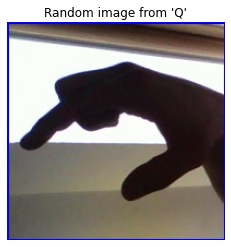

In [294]:
# Get a random image from the training set and test set
def get_random_image(from_validation=False, seed=None):
    if (seed):
        random.seed(seed)
    random_category = random.choice(categories_list)
    random_category_path = os.path.join(test_data_path if from_validation else training_data_path, random_category)
    random_image_path = random.choice(os.listdir(random_category_path))
    image = mpimg.imread(os.path.join(random_category_path, random_image_path))
    return (image, random_category)

image, image_category = get_random_image()
target_size = image.shape

util.show_image(image, title=f"Random image from '{image_category}'")


/Users/olestole/code/unibo/machine-learning/als_classifier/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


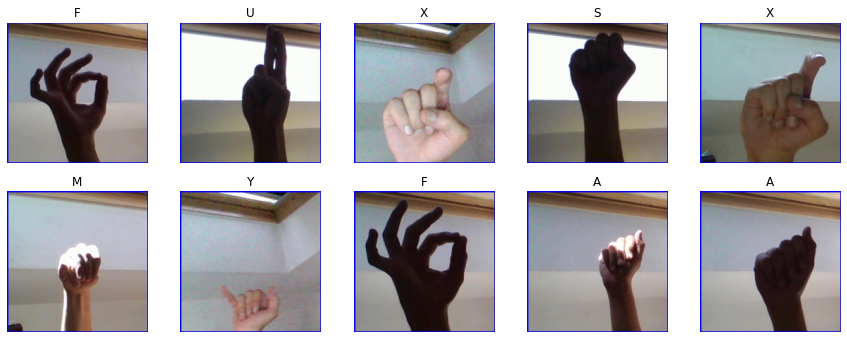

In [295]:
random_images = np.asarray([get_random_image(from_validation=True, seed=i*42) for i in range(10)])
images, titles = random_images[:,0], random_images[:,1]

util.show_images(images, image_titles=titles)

In [296]:
# Randomly split some of the training data into validation data
def sample_images_from_category(category, amount, seed=None, from_validation=False):
    if (seed):
        random.seed(seed)
    category_path = os.path.join(test_data_path if from_validation else training_data_path, category)
    image_path_samples = random.sample(os.listdir(category_path), amount)
    return image_path_samples

# 10% of the training data will be used for validation
split = 0.1
amount = int(3000 * split) # TODO: Change this to be the len of some folder

def move_images_to_validation(amount):
    for category in categories_list:
        image_path_samples = sample_images_from_category(category, amount, seed=42)
        for image_path in image_path_samples:
            source_path = os.path.join(training_data_path, category, image_path)
            destination_path = os.path.join(test_data_path, category)
            shutil.move(source_path, destination_path)

# move_images_to_validation(amount)

# All the data is now preprocessed into their own labelled directory

In [297]:
# Training hyperparameters

EPOCHS = 20
BATCH_SIZE_TRAINING = 64
BATCH_SIZE_VALIDATION = 64
#STEPS_PER_EPOCH = 78300 // BATCH_SIZE_TRAINING
#VALIDATION_STEPS = 8728 // BATCH_SIZE_VALIDATION
STEPS_PER_EPOCH = 100
VALIDATION_STEPS = 100


In [298]:
# Use imagegenetor to generate a batch of images
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1.0/255
)
train_generator = train_datagen.flow_from_directory(
    training_data_path,
    target_size=target_size[:-1],
    batch_size=BATCH_SIZE_TRAINING,
    class_mode='categorical',
)

validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(
    test_data_path,
    target_size=target_size[:-1],
    batch_size=BATCH_SIZE_VALIDATION,
    class_mode='categorical',
)

Found 78300 images belonging to 29 classes.
Found 8728 images belonging to 29 classes.


# Define the model
First we will use the InceptionV3 architecture and imagenet weights. Then we define our own model later on

In [255]:
pre_trained_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    classifier_activation="softmax",
    input_shape = (200, 200, 3),
)

# Make all the layers in the pre-trained model untrainable
for layer in pre_trained_model.layers:
  layer.trainable = False

In [256]:
# The shape of the last layer
last_layer = pre_trained_model.get_layer('mixed10')
print(f"Last layer output shape: {last_layer.output_shape}")

# Get the output of the last layer
last_output = last_layer.output

Last layer output shape: (None, 4, 4, 2048)


In [258]:
# For transfer learning

# Flatten the output from the last layer
# x = tf.keras.layers.Flatten()(last_output)
# x = tf.keras.layers.Dense(512, activation='relu')(x)
# x = tf.keras.layers.Dense(num_categories, activation='softmax')(x)

# Create a connected model from the two definitions
# model = tf.keras.Model(pre_trained_model.input, x)

In [299]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=target_size),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=target_size),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=target_size),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_categories, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_388 (Conv2D)         (None, 198, 198, 16)      448       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 99, 99, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_389 (Conv2D)         (None, 97, 97, 32)        4640      
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_390 (Conv2D)         (None, 46, 46, 64)        18496     
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 23, 23, 64)      

In [300]:
# Checkpoint callback
checkpoint_path = "./data/training_checkpoints/cp6-inceptionV3.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [301]:
# Earlystop callback
class EarlyStopCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('accuracy') >= 0.99):
      print("Reached 99% accuracy so cancelling training!")
      self.model.stop_training = True

In [302]:
callbacks = [EarlyStopCallback()]

In [303]:
# Load the saved weights into the model

load_checkpoint_path = "./data/training_checkpoints/cp2.ckpt"
model.load_weights(load_checkpoint_path)


Two checkpoint references resolved to different objects (<keras.layers.core.dense.Dense object at 0x1593fb0d0> and <keras.layers.core.dropout.Dropout object at 0x156c4e490>).


In [304]:
score = model.evaluate(validation_generator, steps=VALIDATION_STEPS)
print(score)

 14/100 [===>..........................] - ETA: 19s - loss: 0.1235 - accuracy: 0.9621

KeyboardInterrupt: 

In [264]:
history = model.fit(
    train_generator,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS,
    callbacks=callbacks
)

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 7.0851 - accuracy: 0.5406
Epoch 00001: saving model to ./data/training_checkpoints/cp6-inceptionV3.ckpt
100/100 [==============================] - 370s 4s/step - loss: 7.0851 - accuracy: 0.5406 - val_loss: 0.6328 - val_accuracy: 0.8136
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 0.4907 - accuracy: 0.8598
Epoch 00002: saving model to ./data/training_checkpoints/cp6-inceptionV3.ckpt
100/100 [==============================] - 259s 3s/step - loss: 0.4907 - accuracy: 0.8598 - val_loss: 0.4150 - val_accuracy: 0.8680
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 0.3187 - accuracy: 0.9042
Epoch 00003: saving model to ./data/training_checkpoints/cp6-inceptionV3.ckpt
100/100 [==============================] - 236s 2s/step - loss: 0.3187 - accuracy: 0.9042 - val_loss: 0.3533 - val_accuracy: 0.8905
Epoch 4/20
100/100 [==============================] - ETA: 0s - loss: 0.2449 - acc

In [265]:
def save_history(history, file_name = "cnn_history_1.npy"):
    history_path = os.path.join(data_path, file_name)
    np.save(history_path, history.history)
    
def load_history(file_name):
    history_path = os.path.join(data_path, file_name)
    history = np.load(history_path, allow_pickle='TRUE').item()
    return history

In [266]:
save_history(history, "cnn_history_deep_transfer_noaugmentation.npy")

In [57]:
loaded_history = load_history("cnn_history_deep_2.npy")

[0.1899999976158142, 0.5475000143051147, 0.7324010133743286, 0.8228124976158142, 0.8670312762260437, 0.9081249833106995, 0.9260937571525574, 0.9409375190734863, 0.9509742259979248]


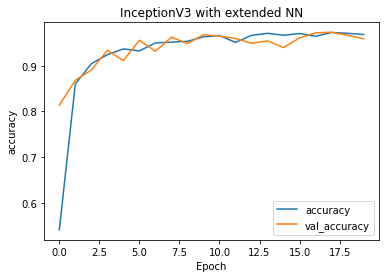

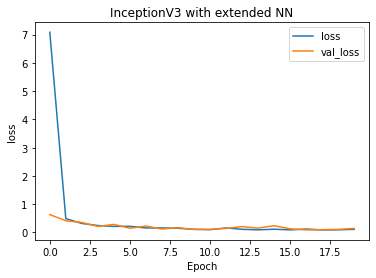

In [305]:
def plot_metric(history, metric, title = None):
    plt.plot(history[metric])
    plt.plot(history['val_' + metric])
    if (title):
        plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])
    plt.show()

plot_metric(history.history, 'accuracy', title="InceptionV3 with extended NN")
plot_metric(history.history, 'loss', title="InceptionV3 with extended NN")

# Use to model to predict

In [217]:
# predict all the images in the validation set
prediciton_res = model.predict(validation_generator)


In [183]:
evaluation_res = model.evaluate(validation_generator)

137/137 [==============================] - 24s 174ms/step - loss: 0.6189 - accuracy: 0.7917


In [268]:
test_images = [plt.imread(img) for img in glob.glob(os.path.join(source_test_data_path, "*"))]
random_images = np.asarray([get_random_image(from_validation=True) for i in range(10)])
images, titles = random_images[:,0], random_images[:,1]


def predict_image(image):
    # Preprocess the image loaded with cv2
    tf_image = tf.keras.utils.img_to_array(image)
    tf_image = tf.expand_dims(tf_image, 0)
    
    # Predict the class of the image using the trained model
    pred = model.predict(tf_image)
    pred_index = np.argmax(pred)
    pred_category = categories_list[pred_index]

    plt.title(f"Prediction: {pred_category}")
    plt.imshow(image)
    plt.show()

def predict_images(image_arr):
    for image in image_arr:
        predict_image(image)


/Users/olestole/code/unibo/machine-learning/als_classifier/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


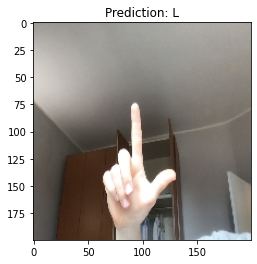

In [306]:
# Reshape the image to fit in the input_size of the model
self_image = cv2.imread("./L_self.jpg")
self_image = cv2.cvtColor(self_image, cv2.COLOR_BGR2RGB)
self_image = cv2.resize(self_image, dsize=target_size[:-1], interpolation=cv2.INTER_CUBIC)

predict_images([self_image])

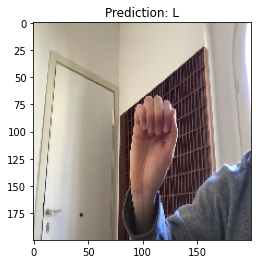

In [310]:
try:
    camera = cv2.VideoCapture(0)
    while True:
        ret, frame = camera.read()
        if not ret:
            print("Can't receive frame (stream end?). Exiting ...")
            break

        frame = cv2.resize(frame, dsize=target_size[:-1], interpolation=cv2.INTER_CUBIC)
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        predict_image(rgb)

        clear_output(wait=True)
except KeyboardInterrupt:
    pass
finally:
    camera.release()
    del(camera)